# Time series plotting around reservoirs

## To-dos
- [ ] sum precip from mm/hr to mm
- [x] spatial aggregation of GRACE subset to single time series
- [x] spatial aggregation of CYGNSS subset to single time series
- [x] spatial aggregation of IMERG subset to single time series
- [ ] convert time series functions & spatial functions to new class

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets
import area_calcs

In [3]:
grace_dict = load_data.load_GRACE()
precip_DA = load_data.load_IMERG()
res_shp = load_data.load_GRanD()

In [4]:
def single_timeseries_IMERG_CYGNSS_GRACE(dam_name,subset_method='polygon',**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    dam_name: name of a dam in the GRanD reservoir dataset
    subset_method : str
        default : 'polygon'
        accepted : 'polygon' , 'point'
        allows for updated polygon or older point-based subsetting
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`

    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip_DA , grace_dict, res_shp
    
    if 'polygon' in subset_method.lower():
        subset_gpd = area_subsets.check_for_multiple_dams(dam_name,res_shp)
        precip_multi , precip_full = area_subsets.precip_shape_subset(
                             subset_gpd,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        
        subset_bbox = subset_gpd.geometry.buffer(0).bounds
        fw_DA = load_data.load_CYGNSS_001_all_months(subset_bbox.values[0])
        fw_multi , fw_full = area_subsets.cygnss_shape_subset(
                             subset_gpd,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        fw_binary = area_calcs.cygnss_convert_to_binary(fw_multi)
        fw_num = area_calcs.CYGNSS_001_areal_average(fw_binary)
        fw_full = pd.Series(data=fw_num, index=fw_full.index)
        
        cmwe_multi , mascon_ts , cmwe_full = area_subsets.grace_shape_subset(
                                subset_gpd,
                                grace_dict,
                                buffer_val=0)        
    elif 'point' in subset_method.lower():
        coords_i = area_subsets.reservoir_name_to_point(res_oi,res_shp)
        
        precip_full = area_subsets.precip_point_subset(coords_i,precip_DA)
        fw_full = area_subsets.cygnss_point_subset(coords_i,fw_DA)
        cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)

    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (15,6)

    plt.rc('font', size=14)
    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)

    return precip , fw , cmwe

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/.conda/envs/rioxarray_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Projected to equal area


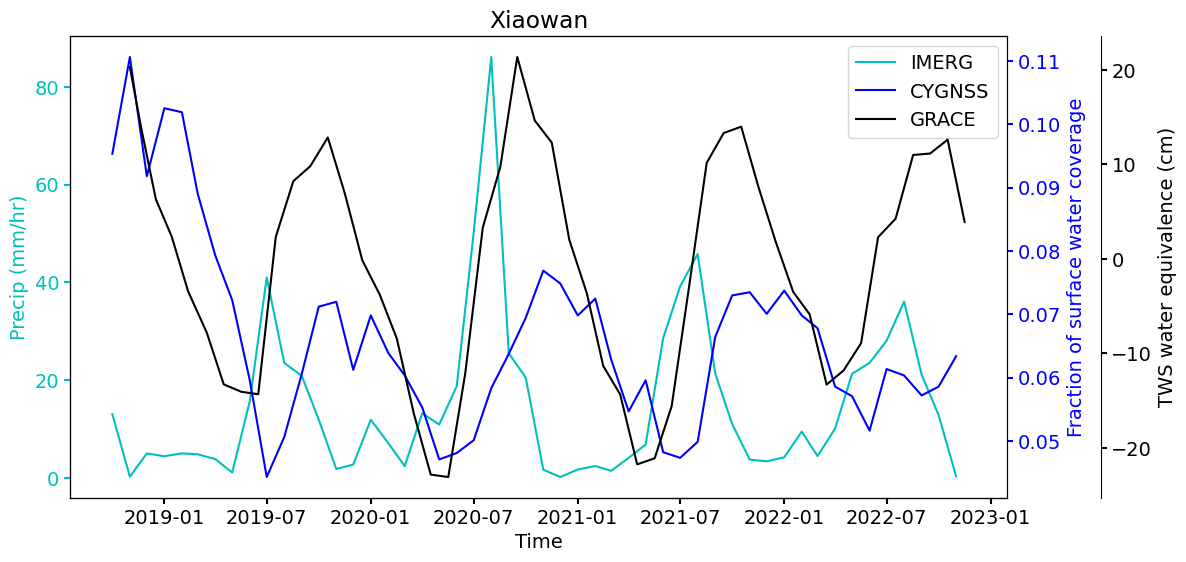

In [18]:
res_oi = 'Xiaowan'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(
    res_oi,
    **plot_params,
    subset_method='polygon')

## Testing fw categories to binary and average

In [34]:
dam_name = 'Merowe'
subset_gpd = area_subsets.check_for_multiple_dams(dam_name,res_shp)

subset_bbox = subset_gpd.geometry.buffer(0).bounds
fw_DA = load_data.load_CYGNSS_001_all_months(subset_bbox.values[0])
fw_multi , fw_full = area_subsets.cygnss_shape_subset(
                        subset_gpd,
                        fw_DA,
                        buffer_val=0.25,
                        crs_code=4326)
fw_binary = area_calcs.cygnss_convert_to_binary(fw_multi)
fw_num = area_calcs.CYGNSS_001_areal_average(fw_binary)
fw_num_pd = pd.Series(data=fw_num, index=fw_full.index)

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/.conda/envs/rioxarray_env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


                 cat       num
2018-08-01  1.105516  0.138095
2018-09-01  1.140182  0.172381
2018-10-01  1.167004  0.197857
2018-11-01  1.158654  0.188571
2018-12-01  1.104504  0.142857
2019-01-01  1.159413  0.191190
2019-02-01  1.141447  0.170952
2019-03-01  1.156883  0.190952
2019-04-01  1.151316  0.186667
2019-05-01  1.120951  0.154286
2019-06-01  1.104504  0.140000
2019-07-01  1.088563  0.122381
2019-08-01  1.093117  0.125714
2019-09-01  1.105263  0.138095
2019-10-01  1.124241  0.157857
2019-11-01  1.131073  0.169048
2019-12-01  1.120951  0.154048
2020-01-01  1.095395  0.128571
2020-02-01  1.074140  0.109048
2020-03-01  1.129302  0.165238
2020-04-01  1.106528  0.139286
2020-05-01  1.119939  0.150952
2020-06-01  1.087804  0.125000
2020-07-01  1.084767  0.117619
2020-08-01  1.071609  0.105000
2020-09-01  1.100962  0.137381
2020-10-01  1.110071  0.146429
2020-11-01  1.080213  0.112381
2020-12-01  1.112854  0.146667
2021-01-01  1.122217  0.158333
2021-02-01  1.080972  0.117381
2021-03-

<Axes: >

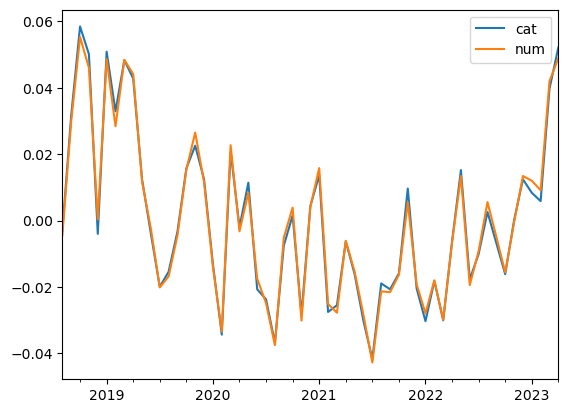

In [39]:
# Checking that the categorical average and numerical average have the same shape.
comp_df = pd.DataFrame(fw_full,columns=['cat'])
comp_df['num'] = fw_num
(comp_df - comp_df.mean()).plot()

## Older time series metrics from TSM class objects

In [ ]:
def series_to_TSM_object(input_series,*TSM_args,**TSM_kwargs):
    series_obj = input_series.astype(float)
    series_obj.index = list(map(time_series_calcs.toYearFraction,series_obj.index))
    TSM_obj = time_series_calcs.TimeSeriesMetrics(series_obj,*TSM_args,**TSM_kwargs)
    return TSM_obj

In [ ]:
precip_ts = series_to_TSM_object(precip_series,'IMERG')
fw_ts = series_to_TSM_object(fw_series,'CYGNSS')
cmwe_ts = series_to_TSM_object(cmwe_series,'GRACE')

In [ ]:
# precip_ts.coef_determination(fw_ts)
# precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
# fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);

## Spatial aggregation work of polygon subset to single time series

In [ ]:
# GRACE = success.
subset_gpd = area_subsets.check_for_multiple_dams('Xiaowan',res_shp,idx=0)
test_cmwe , test_mascon , test_cmwe_agg = area_subsets.grace_shape_subset(subset_gpd,
                                grace_dict,
                                buffer_val=0)
test_cmwe_agg = test_cmwe.mul(test_mascon['area_km2'],axis='index').sum(axis=0)/(test_mascon['area_km2'].sum())
    # weighted average
test_polygon_agg = test_mascon.geometry.unary_union

In [ ]:
# CYGNSS = success.
subset_gpd = area_subsets.check_for_multiple_dams('Xiaowan',res_shp,idx=0)
test_fw = area_subsets.xr_shape_subset(subset_gpd,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
test_fw_agg = test_fw.mean(dim=['lat','lon'])

In [ ]:
# IMERG
subset_gpd = area_subsets.check_for_multiple_dams('Xiaowan',res_shp,idx=0)
test_precip = area_subsets.xr_shape_subset(subset_gpd,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)

## Scratchwork

In [ ]:
coords_i = area_subsets.reservoir_name_to_point('Indirasagar',res_shp)

precip_xr = precip_DA.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),precip_xr['time'].values)))
    # Time = seconds since 1980 Jan 06 (UTC), per original HDF5 IMERG file units
precip_ts = pd.Series(data=precip_xr,index=dates_precip)

In [ ]:
def IMERG_timestamp_to_pdTimestamp(input_xrcoord):
    dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),input_xrcoord.values)))
    return dates_precip

In [ ]:
precip_multi , precip_full = area_subsets.precip_shape_subset(
                        subset_gpd,
                        precip_DA,
                        buffer_val=0.25,
                        crs_code=4326)

In [ ]:
test_bbox.values[0]

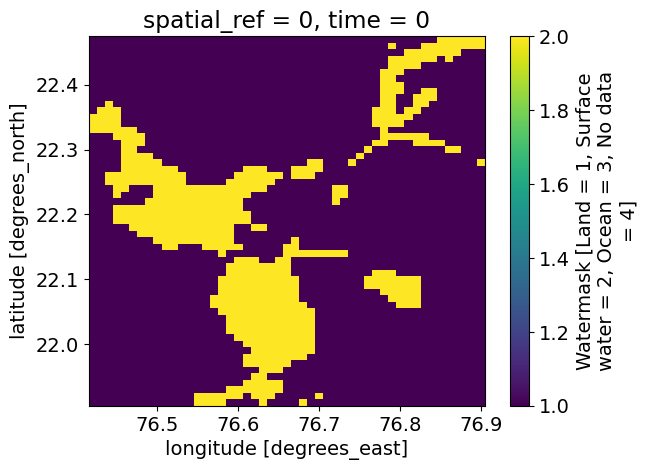

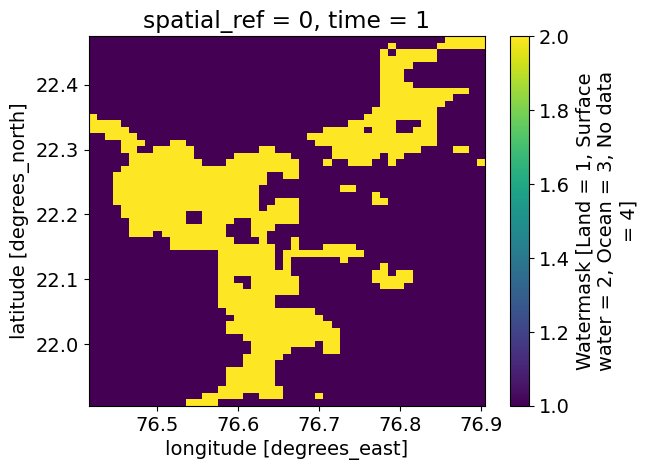

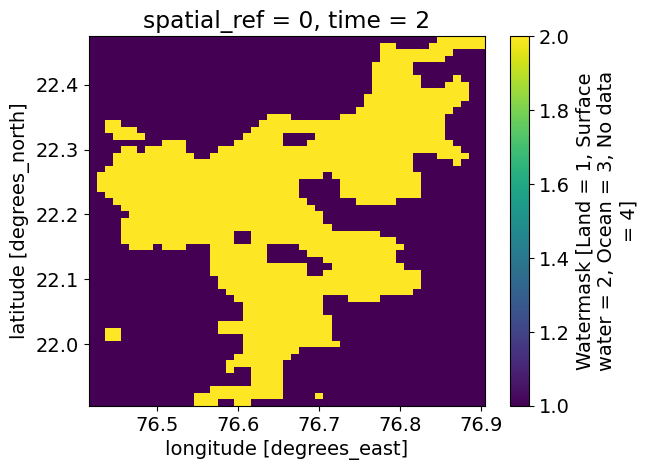

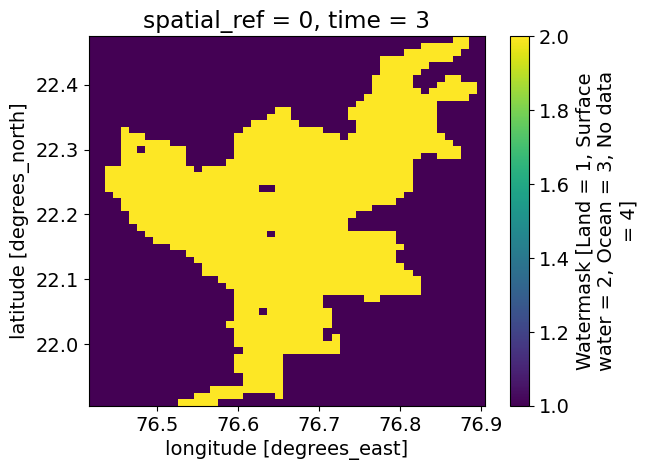

In [43]:
subset_gpd = area_subsets.check_for_multiple_dams('Indirasagar',res_shp,idx=0)
test_bbox = subset_gpd.geometry.buffer(0).bounds

test_cygnss = load_data.load_CYGNSS_001_all_months(test_bbox.values[0])
for i in np.arange(4):
    plt.figure()
    test_cygnss[i,:,:].plot()

In [ ]:
area_subsets.reservoir_name_to_point('Xiaowan',res_shp) , area_subsets.reservoir_name_to_point('Nuozhadu',res_shp)

In [49]:
res_shp[res_shp['DAM_NAME'] =='Sardar Sarovar'].squeeze()

GRAND_ID                                                   4734
RES_NAME                                                    NaN
DAM_NAME                                         Sardar Sarovar
ALT_NAME                                                Narmada
RIVER                                                   Narmada
ALT_RIVER                                                   NaN
MAIN_BASIN                                              Narmada
SUB_BASIN                                                   NaN
NEAR_CITY                                              Rajpipla
ALT_CITY                                                    NaN
ADMIN_UNIT                                              Gujarat
SEC_ADMIN                                                   NaN
COUNTRY                                                   India
SEC_CNTRY                                                   NaN
YEAR                                                       2006
ALT_YEAR                                

In [46]:
res_shp.loc[res_shp['RIVER'] == 'Narmada',['DAM_NAME','RES_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM','LONG_DD','LAT_DD']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,RES_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM,LONG_DD,LAT_DD
4730,Sardar Sarovar,NaN,India,Hydroelectricity,2006,9500.0,73.748676,21.831123
4877,Bargi,NaN,India,Irrigation,1988,3920.0,79.924831,22.941922
6937,Indirasagar,NaN,India,Irrigation,2005,1222.0,76.471948,22.282538
6940,Omkareshwar,NaN,India,Irrigation,2007,987.0,76.161550,22.239079


In [ ]:
res_shp[res_shp['ADMIN_UNIT'] == 'Yunnan']

In [ ]:
res_shp.loc[:,['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

In [11]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM','LONG_DD','LAT_DD']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM,LONG_DD,LAT_DD
7162,Nuozhadu,China,Hydroelectricity,2014,23703.0,100.429623,22.640879
7213,Xiaowan,China,Hydroelectricity,2012,15043.0,100.093825,24.706595
5132,Nam Ngum,Laos,Hydroelectricity,1972,7030.0,102.549100,18.531233
6946,Nam Ngum 2,Laos,Hydroelectricity,2011,4230.0,102.776570,18.753615
6948,Xe Kaman 1,Laos,Hydroelectricity,2015,3210.0,107.159768,14.960122
6944,Nam Theun 2,Laos,Hydroelectricity,2010,3210.0,104.952263,17.996790
5145,Ubol Ratana,Thailand,Irrigation,1966,2263.0,102.617817,16.772725
5792,Sirindhorn,Thailand,Hydroelectricity,1971,1966.0,105.430544,15.205083
7232,Lower Sesan II,Cambodia,Hydroelectricity,2017,1790.0,106.256674,13.552205
5146,Lam Pao,Thailand,Irrigation,1969,1430.0,103.453125,16.603534
